## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data**
- **[Part 3](#part3) -  Class 0 vs All**
- **[Part 4](#part4) -  Class 0 vs All with balanced Data**
- **[Part 5](#part5) -  Random Forest Class 0 vs All balanced data**
- **[Part 6](#part6) - ANN Class 0 vs All balanced data**
- **[Part 7](#part7) - ANN 2 hidden layers Class 0 vs All balanced data**
- **[Part 8](#part8) - XGBoost Class 0 vs All balanced data**



[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [2]:
random.seed(0)

In [3]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [4]:
# Dropping na values for 
df = df.dropna()

In [5]:
# Dropping case_id
df.drop(['case_id'], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data

### Hot Encoded Data

In [6]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [7]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and splitting Data

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

# Models

We will use the best models from our last analysis :
- Random Forest
- ANN Classifier



In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Class 0 vs All

## Preparing Data

In [10]:
y_train0 = np.minimum(1, y_train)
y_test0 = np.minimum(1, y_test)

## Random Forest

In [18]:
# Instantiating and fitting the data
forest0 = RandomForestClassifier(n_estimators=60, criterion='entropy')
forest0.fit(X_train, y_train0)

RandomForestClassifier(criterion='entropy', n_estimators=60)

Accuracy : 0.926


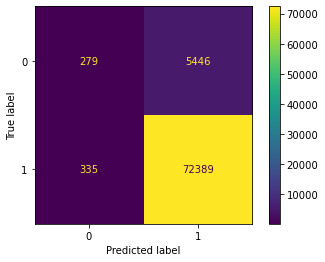

In [23]:
y_pred = forest0.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test0, y_pred))

cm = confusion_matrix(y_test0, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, roc_auc_score
print("Test Precision-",round(precision_score(y_test0, y_pred),3))
print("Test Recall-",round(recall_score(y_test0, y_pred),3))
print("Test ROCAUC", round(roc_auc_score(y_test0, y_pred),3))

Test Precision- 0.93
Test Recall- 0.995
Test ROCAUC 0.522


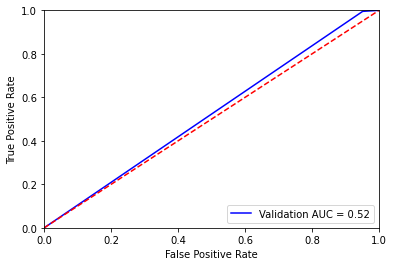

In [25]:
#Validation
fpr_v, tpr_v, _ = roc_curve(y_test0, y_pred)
roc_auc_v = auc(fpr_v, tpr_v)
plt.plot(fpr_v, tpr_v, 'b', label = 'Validation AUC = %0.2f' % roc_auc_v)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Bad classifier, misses a lot

## ANN

In [30]:
model0 = Sequential()
model0.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model0.add(Dense(1,activation='sigmoid'))
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
r = model0.fit(X_train,y_train0,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 8s 44us/sample - loss: 0.2405 - accuracy: 0.9234 - val_loss: 0.2329 - val_accuracy: 0.9238
Epoch 2/50
188275/188275 [==============================] - 7s 37us/sample - loss: 0.2252 - accuracy: 0.9262 - val_loss: 0.2287 - val_accuracy: 0.9236
Epoch 3/50
188275/188275 [==============================] - 7s 37us/sample - loss: 0.2208 - accuracy: 0.9262 - val_loss: 0.2242 - val_accuracy: 0.9242
Epoch 4/50
188275/188275 [==============================] - 7s 37us/sample - loss: 0.2185 - accuracy: 0.9262 - val_loss: 0.2235 - val_accuracy: 0.9237
Epoch 5/50
188275/188275 [==============================] - 8s 43us/sample - loss: 0.2175 - accuracy: 0.9263 - val_loss: 0.2232 - val_accuracy: 0.9236
Epoch 6/50
188275/188275 [==============================] - 7s 38us/sample - loss: 0.2169 - accuracy: 0.9263 - val_loss: 0.2221 - val_accuracy: 0.9239
Epoch 7/50
188275/188275 [=================

Accuracy : 0.927


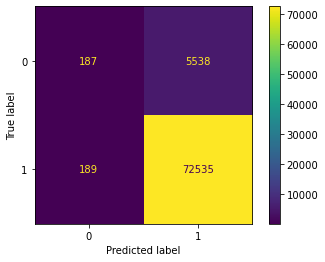

In [35]:
y_pred = model0.predict(X_test) > 0.5
print(f'Accuracy : %.3f' % accuracy_score(y_test0, y_pred))

cm = confusion_matrix(y_test0, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Both confusion matrices for Random Forest and ANN are disappointing we possibly have to handle the imcalanced data

[Back to top](#Content:)


<a id='part4'></a>

# Part 4 -  Class 0 vs All with balanced dataset

In [115]:
ynew = np.minimum(1, y)


In [116]:
# Number of occurence of each class
x0 = len(ynew[ynew==0])
x1 = len(ynew) - x0
    
print(f'Class 0 appears {x0} times')
print(f'Class 1 appears {x1} times')
print('Ration of Class0 : {:%} '.format(x0/(x0+x1))  )

Class 0 appears 23250 times
Class 1 appears 290543 times
Ration of Class0 : 7.409343% 


In [117]:
## Creating new variables to work with
np.unique(ynew)

array([0, 1])

In [118]:
indices0 = np.argwhere(ynew ==0)[:,0]
indices1 = np.argwhere(ynew ==1)[:,0]


In [119]:
print('len(indices0) :', len(indices0))
print('len(indices1) :', len(indices1))

len(indices0) : 23250
len(indices1) : 290543


In [120]:
import random
# Shuffling indices
m = len(indices0)
random.shuffle(indices1)

# Creating new training variables to work with
X0 = X[indices0]
y0 = ynew[indices0]
X1 = X[indices1[:m]]
y1 = ynew[indices1[:m]]

In [121]:
# New training data

X_new = np.concatenate([X0,X1])
y_new = np.concatenate([y0,y1])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.25, random_state=50)



[Back to top](#Content:)


<a id='part5'></a>

# Part 5 -  Random Forest Class 0 vs All balanced data

### model

In [122]:
# Instantiating and fitting the data
forest = RandomForestClassifier(n_estimators=5, criterion='entropy')
forest.fit(X_train_new, y_train_new)

RandomForestClassifier(criterion='entropy', n_estimators=5)

### Performance on training set 

Accuracy : 0.966


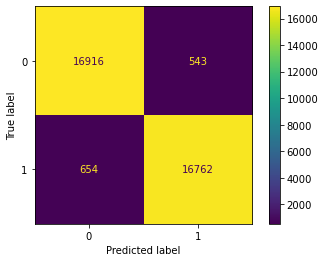

In [123]:
y_train_pred = forest.predict(X_train_new)
print(f'Accuracy : %.3f' % accuracy_score(y_train_new, y_train_pred))

cm = confusion_matrix(y_train_new, y_train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Performance on test set

Accuracy : 0.687


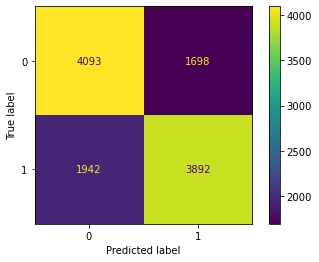

In [124]:
y_pred = forest.predict(X_test_new)
print(f'Accuracy : %.3f' % accuracy_score(y_test_new, y_pred))

cm = confusion_matrix(y_test_new, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Even with balanced data the model didn't learn to generalise well, it looks like it succeds on training set but fails on test set

[Back to top](#Content:)


<a id='part6'></a>

# Part 6 -  ANN Class 0 vs All balanced data

### Model

In [153]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(Dense(32, input_dim=X_train_new.shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))
opt = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

r = model.fit(X_train_new,y_train_new,verbose=1,validation_split=0.2, epochs=150)



Train on 27900 samples, validate on 6975 samples
Epoch 1/150
27900/27900 [==============================] - 2s 62us/sample - loss: 70.5173 - accuracy: 0.5063 - val_loss: 6.8300 - val_accuracy: 0.5137
Epoch 2/150
27900/27900 [==============================] - 1s 41us/sample - loss: 12.2560 - accuracy: 0.5104 - val_loss: 6.3296 - val_accuracy: 0.5130
Epoch 3/150
27900/27900 [==============================] - 1s 43us/sample - loss: 12.6191 - accuracy: 0.5125 - val_loss: 1.1652 - val_accuracy: 0.6443
Epoch 4/150
27900/27900 [==============================] - 1s 42us/sample - loss: 13.0991 - accuracy: 0.5280 - val_loss: 17.8351 - val_accuracy: 0.4996
Epoch 5/150
27900/27900 [==============================] - 1s 44us/sample - loss: 11.6394 - accuracy: 0.5293 - val_loss: 10.9500 - val_accuracy: 0.5110
Epoch 6/150
27900/27900 [==============================] - 1s 42us/sample - loss: 11.5222 - accuracy: 0.5272 - val_loss: 32.7711 - val_accuracy: 0.5068
Epoch 7/150
27900/27900 [=================

27900/27900 [==============================] - 1s 40us/sample - loss: 7.1979 - accuracy: 0.6052 - val_loss: 4.0217 - val_accuracy: 0.6389
Epoch 109/150
27900/27900 [==============================] - 1s 40us/sample - loss: 8.6768 - accuracy: 0.5971 - val_loss: 6.1130 - val_accuracy: 0.6062
Epoch 110/150
27900/27900 [==============================] - 1s 40us/sample - loss: 6.1350 - accuracy: 0.6084 - val_loss: 3.3498 - val_accuracy: 0.6075
Epoch 111/150
27900/27900 [==============================] - 1s 40us/sample - loss: 6.6201 - accuracy: 0.6092 - val_loss: 2.0754 - val_accuracy: 0.6935
Epoch 112/150
27900/27900 [==============================] - 1s 41us/sample - loss: 7.1397 - accuracy: 0.5977 - val_loss: 3.4262 - val_accuracy: 0.6508
Epoch 113/150
27900/27900 [==============================] - 1s 40us/sample - loss: 6.4888 - accuracy: 0.6105 - val_loss: 10.7994 - val_accuracy: 0.5351
Epoch 114/150
27900/27900 [==============================] - 1s 40us/sample - loss: 7.4543 - accuracy

### Performance on test set

Accuracy : 0.647


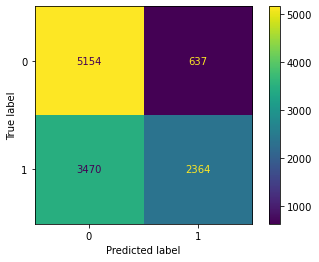

In [154]:
y_pred = model.predict(X_test_new) 
y_pred = 1*(y_pred > 0.5)
print(f'Accuracy : %.3f' % accuracy_score(y_test_new, y_pred))

cm = confusion_matrix(y_test_new, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

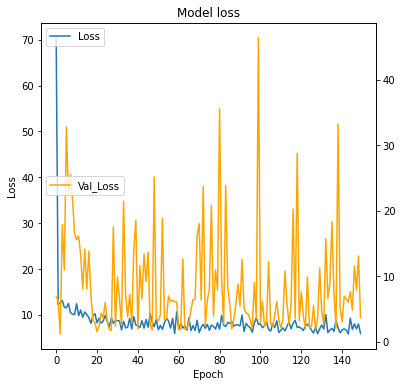

In [158]:
# Plotting
plt.figure(figsize=(6,6))

plt.plot(r.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')



plt.show()


Accuracy of the Neural network is lower than Random Forest

[Back to top](#Content:)


<a id='part7'></a>

# Part 7 -  ANN 2 hidden layers Class 0 vs All balanced data

In [167]:
model = Sequential()
model.add(Dense(32, input_dim=X_train_new.shape[1], activation='relu'))
model.add(Dense(12, input_dim=X_train_new.shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))
opt = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

r = model.fit(X_train_new,y_train_new,verbose=1,validation_split=0.2, epochs=150)

Train on 27900 samples, validate on 6975 samples
Epoch 1/150
27900/27900 [==============================] - 2s 68us/sample - loss: 65.8645 - accuracy: 0.5004 - val_loss: 47.1815 - val_accuracy: 0.5052
Epoch 2/150
27900/27900 [==============================] - 1s 47us/sample - loss: 17.2065 - accuracy: 0.5062 - val_loss: 33.1616 - val_accuracy: 0.5057
Epoch 3/150
27900/27900 [==============================] - 1s 44us/sample - loss: 17.6480 - accuracy: 0.5046 - val_loss: 27.0411 - val_accuracy: 0.4973
Epoch 4/150
27900/27900 [==============================] - 1s 44us/sample - loss: 13.8505 - accuracy: 0.5118 - val_loss: 1.7113 - val_accuracy: 0.5471
Epoch 5/150
27900/27900 [==============================] - 1s 48us/sample - loss: 15.0562 - accuracy: 0.5091 - val_loss: 9.8004 - val_accuracy: 0.4975
Epoch 6/150
27900/27900 [==============================] - 1s 47us/sample - loss: 15.3020 - accuracy: 0.5136 - val_loss: 13.5727 - val_accuracy: 0.4978
Epoch 7/150
27900/27900 [================

Epoch 55/150
27900/27900 [==============================] - 1s 45us/sample - loss: 6.0283 - accuracy: 0.5797 - val_loss: 6.2487 - val_accuracy: 0.5355
Epoch 56/150
27900/27900 [==============================] - 1s 44us/sample - loss: 5.6794 - accuracy: 0.5792 - val_loss: 2.1552 - val_accuracy: 0.6496
Epoch 57/150
27900/27900 [==============================] - 1s 45us/sample - loss: 6.6064 - accuracy: 0.5718 - val_loss: 4.6618 - val_accuracy: 0.5333
Epoch 58/150
27900/27900 [==============================] - 1s 45us/sample - loss: 5.7938 - accuracy: 0.5800 - val_loss: 6.0264 - val_accuracy: 0.5693
Epoch 59/150
27900/27900 [==============================] - 1s 46us/sample - loss: 5.5143 - accuracy: 0.5792 - val_loss: 5.1562 - val_accuracy: 0.5794
Epoch 60/150
27900/27900 [==============================] - 1s 46us/sample - loss: 7.1390 - accuracy: 0.5722 - val_loss: 5.4919 - val_accuracy: 0.5583
Epoch 61/150
27900/27900 [==============================] - 1s 45us/sample - loss: 5.2658 - ac

### Performance on test set

Accuracy : 0.648


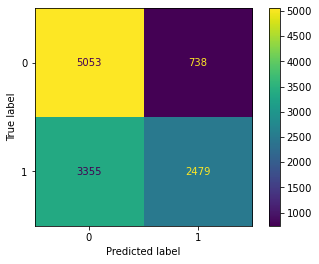

In [168]:
y_pred = model.predict(X_test_new) > 0.5
print(f'Accuracy : %.3f' % accuracy_score(y_test_new, y_pred))

cm = confusion_matrix(y_test_new, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

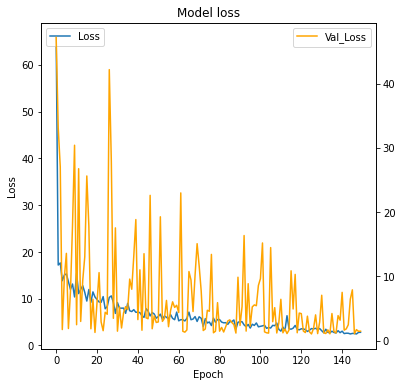

In [169]:
# Plotting
plt.figure(figsize=(6,6))

plt.plot(r.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')



plt.show()

After experimenting with differenet paramaters (learning rate, optimizers, regularizers ... ) The best result are from the two models here and it looks like the NN settles on an accuracy of 60% which is not enough, let's try XGBoost to compare

[Back to top](#Content:)


<a id='part8'></a>

# Part 8 -  XGBoost Class 0 vs All balanced data

In [170]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_new, y_train_new)

/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:29:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy : 0.739


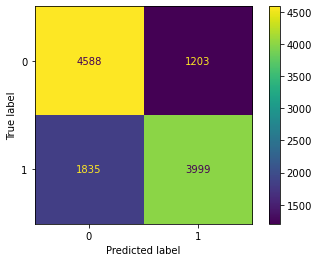

In [171]:
y_pred = xgb.predict(X_test_new)
print(f'Accuracy : %.3f' % accuracy_score(y_test_new, y_pred))
cm = confusion_matrix(y_test_new, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

XGBoost accuracy is higher than our Random Forest classifier.

### Testing on the real test set

Accuracy : 0.153


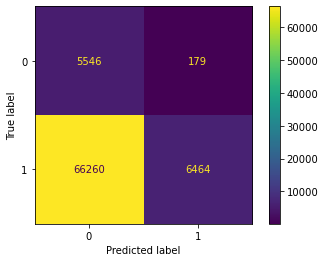

In [175]:
y_pred = xgb.predict(X_test)
y_test_n = np.minimum(y_test,1)
print(f'Accuracy : %.3f' % accuracy_score(y_test_n, y_pred))
cm = confusion_matrix(y_test_n, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

From the confusion matrix we can see that the classifier fails to generalize well ag